In [ ]:
from getpass import getpass
from shapely.geometry import mapping

import geopandas as gpd
import pandas as pd

from helpers import stats_to_df, authenticate_sentinel_hub, build_json_request

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Authentication
To use **Sentinel Hub API**, you need to authenticate with using **OAuth2** credentials. These are available from your [Sentinel Hub Dashboard](https://apps.sentinel-hub.com/dashboard/),

Get your `CLIENT_ID` and `CLIENT_SECRET` from the **Dashboard** -> **My Account** _> **OAuth Clients**.
Get your `DATA_SET` ID from [Insight Platform](https://insights.planet.com/analyze/configurations/) -> **Your Collection** -> **Collection ID**

In [2]:
CLIENT_ID = getpass("Enter your Sentinel Hub CLIENT_ID: ")
CLIENT_SECRET = getpass("Enter your Sentinel Hub CLIENT_SECRET: ")
DATA_SET = getpass("Enter you data ID")

oauth = authenticate_sentinel_hub(CLIENT_ID, CLIENT_SECRET)

# Get Your Data Ready

Provide a **GeoJSON** file containing the geographic area or features you want to work with, the start and end date (YYYYY-MM-DD) for the timeframe of your analyses, and the desired day interval

In [14]:
data = "test_bbox_landcover.geojson" 
start_date = "2023-01-01"
end_date = "2023-12-30"
day_interval = '1' #the interval of days for which data will be retrieved. For daily analyses set day_interval = 1
results = []

### How to make multiple requests for a collection of geometries

In this example, we will collect [Land Surface Temperature (LST)](https://docs.planet.com/data/planetary-variables/land-surface-temperature/techspec/) values for `4` small polygons, each marking a different land cover type: `urban`, `palm_plantations`, `low_vegetation` and `forest`.

For this we will use the Statistical API of Sentinel Hub, as it allows us to obtain statistical information for a large collection of small geometries. Note, that this woeks only for polygons, currunt inplementation of the API does not allow us to do those analyses with point data.

In [15]:
geodataframe = gpd.read_file(data)
geodataframe = geodataframe.to_crs("EPSG:4326")
geodataframe

,FID,Shape_Leng,Shape_Area,land_type,geometry
0,0,800,40000,urban,"POLYGON ((-83.52432 8.96078, -83.52252 8.96078..."
1,1,800,40000,palm_plantatios,"POLYGON ((-83.53869 8.96793, -83.5369 8.96793,..."
2,2,800,40000,low_vegetation,"POLYGON ((-83.55127 8.9715, -83.54947 8.9715, ..."
3,3,800,40000,forest,"POLYGON ((-83.50456 8.98579, -83.50276 8.98579..."


# 

For each polygon, we send a JSON request to the Statistical API. We store the JSON response, containing the results, in a list, that we will convert later in a pandas dataframe for easier handling.

In [ ]:
for geoshape in geodataframe.geometry.values:
  geometry = mapping(geoshape)

  # Build JSON
  json_request = build_json_request(geometry, start_date, end_date, day_interval, DATA_SET)

  # Set the request url and headers
  url = "https://services.sentinel-hub.com/api/v1/statistics"
  headers = {
  "Accept": "application/json",
  "Content-Type": "application/json"
  }

  #Send the request
  response = oauth.request(
    "POST", url, headers=headers, json = json_request
  )

  results.append(response.json())


Let's now convert this data into a tabular form by transforming it into a `pandas` dataframe.

In [17]:
dataframe = [stats_to_df(result) for result in results]

for df, land_type in zip(dataframe, geodataframe['land_type'].values):
    df["land_type"] = land_type

dataframe = pd.concat(dataframe)

dataframe

,interval_from,interval_to,eobrowserStats_B0_min,eobrowserStats_B0_max,eobrowserStats_B0_mean,eobrowserStats_B0_stDev,eobrowserStats_B0_sampleCount,eobrowserStats_B0_noDataCount,land_type
0,2023-01-01,2023-01-02,305.820007,311.850006,309.760868,2.000410,65536,0,urban
1,2023-01-03,2023-01-04,305.420013,311.390015,309.328156,1.980290,65536,0,urban
2,2023-01-05,2023-01-06,305.579987,311.589996,309.498414,2.003107,65536,0,urban
3,2023-01-07,2023-01-08,306.480011,312.010010,309.993847,2.002006,65536,0,urban
4,2023-01-08,2023-01-09,306.130005,311.600006,309.600144,1.978393,65536,0,urban
...,...,...,...,...,...,...,...,...,...
222,2023-12-23,2023-12-24,302.929993,306.549988,304.742075,0.722581,65536,0,forest
223,2023-12-25,2023-12-26,302.130005,305.640015,303.878062,0.703848,65536,0,forest
224,2023-12-26,2023-12-27,299.959991,303.119995,301.544183,0.631181,65536,0,forest
225,2023-12-27,2023-12-28,299.179993,302.239990,300.707395,0.613329,65536,0,forest


# Visualisation 

Now we will plot the time series of LST mean values for each landcover type.

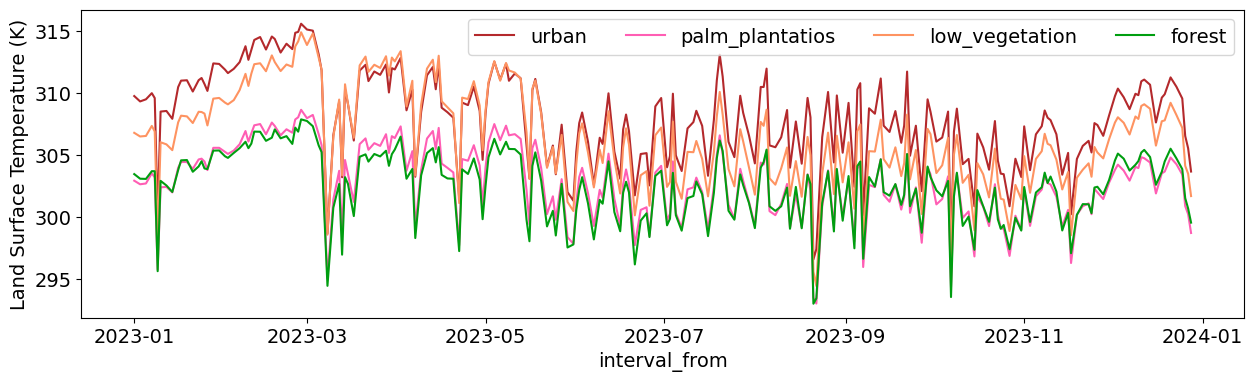

In [31]:
custom_color_map = {
    "urban": "#b4292c",       # red
    "forest": "#009E10",      # green
    "palm_plantatios": "#ff5eb4",       # blue
    "low_vegetation": "#FE9361"  # purple
}

fig, ax = plt.subplots(figsize=(15, 4))
ax.set_ylabel("Land Surface Temperature (K)")
ax.set_xlabel("Date")
plt.rcParams.update({'font.size': 14})


for idx, land_type in enumerate(geodataframe["land_type"].values):
    series = dataframe[dataframe["land_type"] == land_type]
    color = custom_color_map.get(land_type, "gray")  # fallback color in case of typo or unexpected type


    series.plot(ax=ax, x="interval_from", y="eobrowserStats_B0_mean", color=color, label=land_type)

    # ax.fill_between(
    #     series.interval_from.values,
    #     series["eobrowserStats_B0_mean"] - series["eobrowserStats_B0_mean"],
    #     series["eobrowserStats_B0_mean"] + series["eobrowserStats_B0_mean"],
    #     color=f"C{idx}",
    #     alpha=0.3,
    # );
ax.legend(ncol=4)

As you can see the data has some outliers. We will clean it up and make it look a bit nices by using the mean values from a 10 day rolling window.

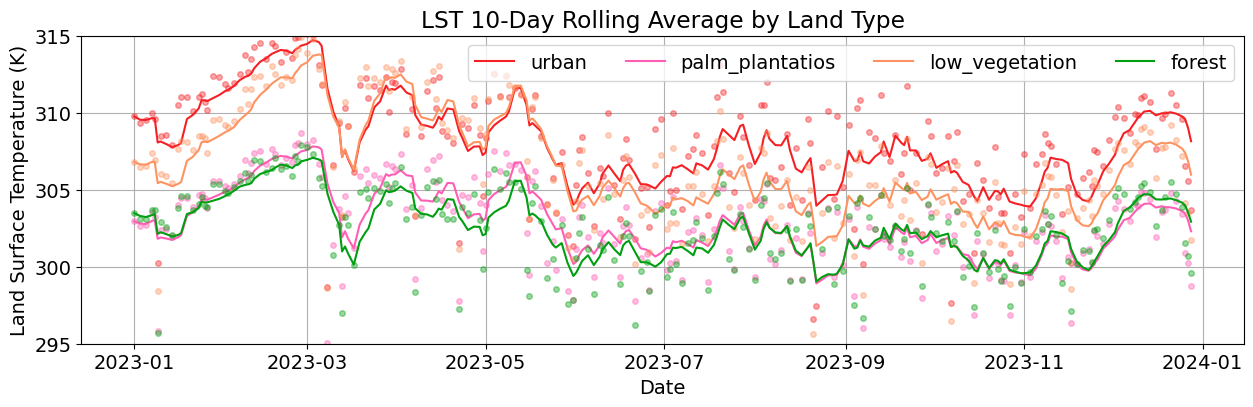

In [ ]:
backward_average_window_size = 10  # in days

custom_color_map = {
    "urban": "#f62024",
    "forest": "#009E10",
    "palm_plantatios": "#ff5eb4",
    "low_vegetation": "#FE9361"
}

fig, ax = plt.subplots(figsize=(15, 4))
ax.set_ylabel("Land Surface Temperature (K)")
ax.set_xlabel("Date")
plt.rcParams.update({'font.size': 14})

for land_type in geodataframe["land_type"].values:
    series = dataframe[dataframe["land_type"] == land_type].copy()

    # Ensure interval_from is datetime and set as index
    series["interval_from"] = pd.to_datetime(series["interval_from"])
    series = series.set_index("interval_from").sort_index()

    # Apply rolling average with a time-based window
    rolling_avg = (
        series["eobrowserStats_B0_mean"]
        .rolling(window=f"{backward_average_window_size}D", min_periods=1)
        .mean()
    )
    ax.plot(series.index, series["eobrowserStats_B0_mean"],
        linestyle='none', marker='o', markersize=4, alpha=0.4,
        color = custom_color_map.get(land_type, "gray"))

    # Plot the smoothed line
    ax.plot(rolling_avg.index, rolling_avg.values,
            color=custom_color_map.get(land_type, "gray"),
            label=land_type)

# Legend and finishing touches
ax.legend(ncol=4)
ax.set_title(f"LST {backward_average_window_size}-Day Rolling Average by Land Type")
ax.set_ylim([295, 315])
ax.grid(True)
